# DTSA-5511 Week 4 Programming Assignment

The objective of this assignment is to use the [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/competitions/nlp-getting-started/overview) Kaggle competition data to compare the performance of three different recurrent neural network (RNN) models for performing a text classification. The architectures I tried are the SimpleRNN, LSTM, and GRU models from the [Keras](https://keras.io/) package.

The dataset contains 7613 tweets with an average length of 15 words. Each tweet is labeled with a target of `1` or `0` (`1` indicating that the tweet is about a real disaster, and `0` indicating no disaster). The goal is to train models that can correctly separate disaster-related tweets from tweets that are not about disasters.

The challenge here is that the non-disaster-related tweets often contain language that might easily fool a model if keywords were taken in isolation (e.g., "Has an accident changed your life?" vs "Car accident on I-75..."). This requires the models to develop a sense of context, which RNNs are capable of doing in their hidden state vectors.

This notebook was run in a Google Collab environment. I based the Keras code on this post: https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/.


## Import Kaggle Data

In [6]:
from google.colab import files

In [ ]:
files.upload()

In [8]:
!pwd

/content


In [9]:
!mkdir -p /root/.config/kaggle

In [10]:
!mv kaggle.json /root/.config/kaggle/

In [11]:
!chmod 600 /root/.config/kaggle/kaggle.json

In [12]:
!kaggle competitions download -c nlp-getting-started

  0% 0.00/593k [00:00<?, ?B/s]
100% 593k/593k [00:00<00:00, 930MB/s]


In [13]:
!unzip -q nlp-getting-started.zip

## EDA

In [14]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense, Dropout

Let's view a snapshot of the training dataset. We see that each tweet (`text`) is labeled in the `target` column. For some tweets, a `keyword` and `location` are associated as well.

In [15]:
train_df = pd.read_csv('train.csv')
train_df.head(100)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
95,137,accident,Charlotte,9 Mile backup on I-77 South...accident blockin...,1
96,138,accident,"Baton Rouge, LA",Has an accident changed your life? We will hel...,0
97,139,accident,"Hagerstown, MD",#BREAKING: there was a deadly motorcycle car a...,1
98,141,accident,"Gloucestershire , UK",@flowri were you marinading it or was it an ac...,0


Number of tweets in the training set

In [16]:
len(train_df)

7613

Average tweet length from the training set

In [17]:
np.round(train_df['text'].apply(lambda x: len(x.split())).mean())

np.float64(15.0)

Minimum tweet length

In [18]:
train_df['text'].apply(lambda x: len(x.split())).min()

1

Maximum tweet length

In [19]:
MAX_SEQUENCE_LENGTH = train_df['text'].apply(lambda x: len(x.split())).max()
MAX_SEQUENCE_LENGTH

31

Distribution of tweet lengths

<Axes: >

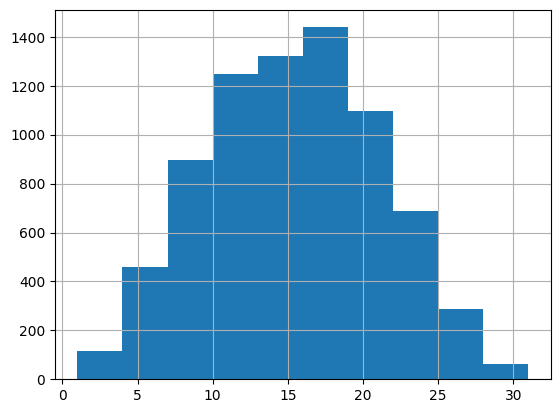

In [20]:
train_df['text'].apply(lambda x: len(x.split())).hist()

There are 221 unique values in the `keyword` column.

In [21]:
train_df['keyword'].value_counts()

,count
keyword,
fatalities,45
deluge,42
armageddon,42
damage,41
body%20bags,41
...,...
forest%20fire,19
epicentre,12
threat,11


The `location` column has 3,341 unique values.

In [22]:
train_df['location'].value_counts()

,count
location,
USA,104
New York,71
United States,50
London,45
Canada,29
...,...
"Silesia, Poland",1
"Hickville, USA",1
New York NYC,1


The distriution of `1` and `0` in the `target` column is slightly skewed toward `0` (no disaster). We'll have to make sure that the train and validation sets preserve this distribution.

In [23]:
train_df['target'].value_counts()

,count
target,
0,4342
1,3271


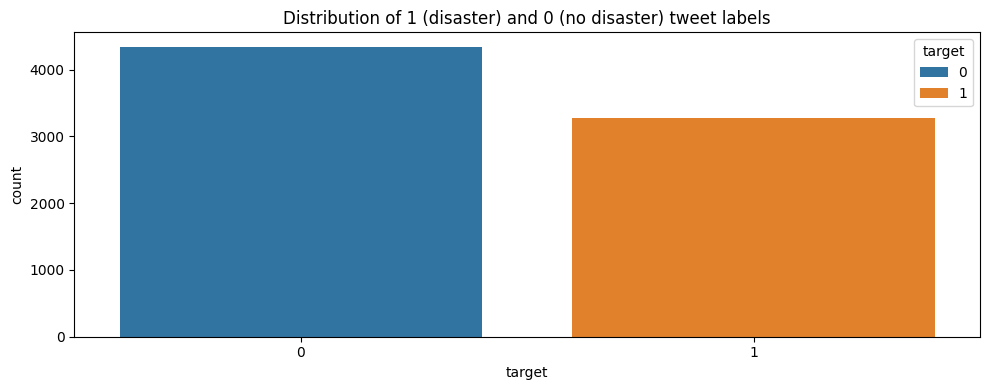

In [24]:
plt.figure(figsize=(10, 4))
sns.countplot(data=train_df, x="target", order=train_df['target'].value_counts().index, hue='target')
plt.title("Distribution of 1 (disaster) and 0 (no disaster) tweet labels")
plt.tight_layout()
plt.show()

The test dataset contains all the same columns as the training dataset except for the `target` column.

In [25]:
test_df = pd.read_csv('test.csv')
test_df.head(100)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
95,323,annihilated,NaN,'If your nature appropriates it love will burn...
96,324,annihilated,NaN,@NinaHoag - 'if you shred my Psych work our fr...
97,325,annihilated,upstate NY,@thehill this is 1 example of y the Conservati...
98,326,annihilated,NaN,Aug 3 1915ÛÓKAISERJAEGERS WIPED OUT.; Francis...


## Import Pre-trained Embeddings

I decided to use [GloVe](https://nlp.stanford.edu/projects/glove/) pre-trained word embeddings as a foundation for training the RNN models (see https://keras.io/examples/nlp/pretrained_word_embeddings/). These are vectorizations of words (tokens) learned from a large corpus of text (Wikipedia and Gigaword data). I chose a dimension of 100 for the vectors as a tradeoff between depth of semantic relationships and model training efficiency.

In [26]:
!curl -L -O https://nlp.stanford.edu/data/wordvecs/glove.2024.wikigiga.100d.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0   371    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  554M  100  554M    0     0  5256k      0  0:01:48  0:01:48 --:--:-- 5131k


In [27]:
!unzip glove.2024.wikigiga.100d.zip

Archive:  glove.2024.wikigiga.100d.zip
  inflating: wiki_giga_2024_100_MFT20_vectors_seed_2024_alpha_0.75_eta_0.05.050_combined.txt  


`glove_dict` has the tokens as keys and their associated 100-dimensional vectors as values. Tokens can be words, parts of words, and also punctuation.

In [28]:
EMBEDDING_DIMENSION = 100
glove_file = 'wiki_giga_2024_100_MFT20_vectors_seed_2024_alpha_0.75_eta_0.05.050_combined.txt'
glove_dict = {}
num_lines_skipped = 0
with open(glove_file, 'r', encoding='utf-8') as f:
    total_number_lines = len(f.readlines())
    print(f"Total number of lines in the GloVe file before pruning: {total_number_lines}.")
with open(glove_file, 'r', encoding='utf-8') as f:
    for line in f:
        line_split_list = line.split()
        token = line_split_list[0]
        try:
            embedding = np.array(line_split_list[1:], dtype='float32')
            if len(embedding) == EMBEDDING_DIMENSION:
                glove_dict[token] = embedding
            else:
                num_lines_skipped += 1
        except ValueError:
            num_lines_skipped += 1
            continue

print(f"Total lines skipped from the original GloVe file: {num_lines_skipped}.")
first_3_items = dict(itertools.islice(glove_dict.items(), 3))
first_3_items

Total number of lines in the GloVe file before pruning: 1291147.
Total lines skipped from the original GloVe file: 3533.


{'the': array([ 0.306717, -0.32053 , -0.393647,  0.082826,  0.073522, -0.409154,
        -0.265564, -0.23694 , -0.305832,  0.74529 ,  0.214341,  0.276781,
        -0.152797, -0.127524,  0.119525,  0.640965, -0.175869,  0.160711,
         0.477978, -0.160939, -0.150093,  0.674601, -0.099565,  0.021882,
        -0.032771,  0.368641, -0.087019, -0.133326,  0.170143,  0.156934,
         0.677506, -0.099686,  0.392113,  0.373434, -5.736062,  0.413845,
         0.477368, -0.041697,  0.383109,  0.120152, -0.20947 ,  0.605104,
         0.236353,  0.151131, -0.508865,  0.671239, -0.300263, -0.267927,
         2.549487,  0.067177,  0.217224, -0.031316,  0.05231 ,  0.119321,
        -0.332154, -0.807904, -0.546453, -0.044392, -0.281657,  0.286647,
         0.325775, -0.02196 , -0.636903, -0.268063,  0.247956, -0.402493,
         0.276707, -0.275139,  0.201159,  0.082844,  0.591695, -0.017127,
        -0.092269,  0.392008,  0.078245, -0.049907,  0.235151,  0.457376,
        -0.111987, -0.05691 ,  

The `Tokenizer()` object from Keras is used to assign integers to each unique token in the `train_df.text` column.

In [29]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['text'])
word_index = tokenizer.word_index
VOCAB_SIZE = len(word_index) + 1 # Add one for keras padding token

print("Token: Index from disaster tweets")
for word, index in list(word_index.items())[:10]:
    print(f"{word}: {index}")

print(f"\nTotal vocabulary size is {VOCAB_SIZE}.")

Token: Index from disaster tweets
t: 1
co: 2
http: 3
the: 4
a: 5
in: 6
to: 7
of: 8
and: 9
i: 10

Total vocabulary size is 22701.


`embedding_matrix` is formed by placing vectors for tokens that exist in `glove_dict` into the row indexed by the integer in the `word_index` dictionary (from `Tokenizer()`). If a word from `word_index` is not in `glove_dict`, then the row at that index remains full of zeroes. Later, we will make adjustments to these embedding vectors as they are treated like weights modified through backpropagation.

In [30]:
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIMENSION))

words_not_found = []
for word, index in word_index.items():
    embedding_vector = glove_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
    else:
        words_not_found.append(word)

print(f"Shape of embedding matrix: {embedding_matrix.shape}")
print(f"Number of tokens not found in the GloVe file: {len(words_not_found)}")

print(f"First 10 tokens not found: {words_not_found[:10]}")

Shape of embedding matrix: (22701, 100)
Number of tokens not found in the GloVe file: 9641
First 10 tokens not found: ["i'm", "it's", "don't", "can't", "you're", '\x89û', "that's", 'gonna', "i've", "he's"]


## Model Training

Because the tweets do not all have the same length, we need to pad them by 0 and give them a uniform length. The tweet vectors are placed into the rows of a matrix (`X`). Each non-zero element in the vectors is an integer representing a token (i.e. a row index) from `embedding_matrix`.

We also create a vector of the `target` values we'll call `y`.

In [31]:
# Convert tweets into sequences of integers (for embedding vector lookup)
sequences = tokenizer.texts_to_sequences(train_df['text'])

# Pad sequences so they are all the max length from the tweets
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

# Define training label vector
y = np.array(train_df['target'])

print("Shape of data matrix (X):", X.shape)
print("Shape of label vector (y):", y.shape)

Shape of data matrix (X): (7613, 31)
Shape of label vector (y): (7613,)


In [32]:
X[0:5] # View the first 5 rows of the X matrix

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,  119, 4633,   24,    4,
         868,    8,   21,  263,  138, 1619, 4634,   89,   40],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,  189,   45,  229,  799, 6954, 6955, 1404],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,   40, 1751,
        1620,    7, 6956,    6, 6957,   24,  136, 6958,   20, 1752,   39,
         441,  256,   57, 2158,    6,  714, 1405,   24, 1106],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
         835, 2921,   59, 4635, 1500,  256, 1405,    6,   96],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,   34,  100, 1221,   21,  320,   22, 6959,
        

### Model 1

The first model we'll train is a "vanilla" RNN. The structure is embeddings -> RNN (with a hidden state vector length of 64) -> densely connected layer for classification (trained with 0.5 dropout to avoid overfitting the training data) -> densely connected binary output layer.

In [33]:
model_vanilla_RNN = Sequential([
        # Embedding layer, initialized with pre-trained GloVe weights
        Embedding(
            input_dim=VOCAB_SIZE,
            output_dim=EMBEDDING_DIMENSION,
            weights=[embedding_matrix],
            input_length=MAX_SEQUENCE_LENGTH,
            trainable=True,  # Allow the embeddings to be adjusted in backpropagation
            name='embedding_layer'
        ),
        SimpleRNN(64, name='simple_rnn_layer'),

        # Dropout layer for the classifier to prevent overfitting
        Dropout(0.5, name='dropout_layer'),

        # Final binary classifier
        Dense(1, activation='sigmoid', name='output_layer') # Custom name for the Dense layer
    ], name='vanilla_rnn_model')

model_vanilla_RNN.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_vanilla_RNN.build(input_shape=(None, MAX_SEQUENCE_LENGTH))
model_vanilla_RNN.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "vanilla_rnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ (None, 31, 100)        │     2,270,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_layer (SimpleRNN)    │ (None, 64)             │        10,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,280,725 (8.70 MB)

 Trainable params: 2,280,725 (8.70 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# Use stratify=y to maintain the same proportion of target classes in both splits
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

EPOCHS_1 = 10
history_1 = model_vanilla_RNN.fit(
    X_train, y_train,
    epochs=EPOCHS_1,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.5829 - loss: 0.7073 - val_accuracy: 0.7912 - val_loss: 0.5022
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7903 - loss: 0.4836 - val_accuracy: 0.8056 - val_loss: 0.4615
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8518 - loss: 0.3673 - val_accuracy: 0.8037 - val_loss: 0.4660
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8873 - loss: 0.2813 - val_accuracy: 0.8096 - val_loss: 0.4794
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9238 - loss: 0.2122 - val_accuracy: 0.8109 - val_loss: 0.5268
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9553 - loss: 0.1370 - val_accuracy: 0.8050 - val_loss: 0.5946
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9758 - loss: 0.0813 - val_accuracy: 0.7879 - val_loss: 0.6315
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9863 - loss: 0.0497 - val_accu

In [35]:
print(history_1.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


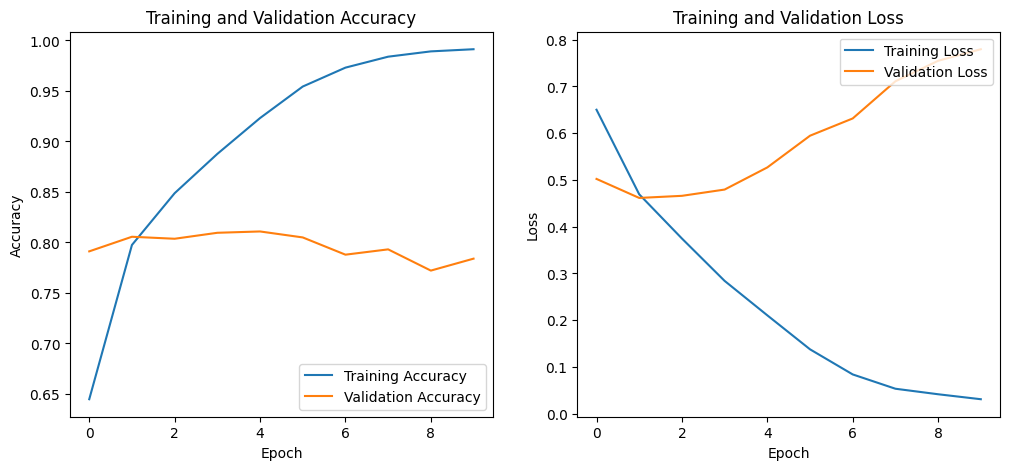

In [36]:
# Get the metrics from the history object
acc_1 = history_1.history['accuracy']
val_acc_1 = history_1.history['val_accuracy']
loss_1 = history_1.history['loss']
val_loss_1 = history_1.history['val_loss']

epochs_range = range(EPOCHS_1)

plt.figure(figsize=(12, 5))

# Plot 1: Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_1, label='Training Accuracy')
plt.plot(epochs_range, val_acc_1, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Plot 2: Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_1, label='Training Loss')
plt.plot(epochs_range, val_loss_1, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

In [37]:
# Make predictions on the validation set
y_pred_prob = model_vanilla_RNN.predict(X_val)
y_pred = (y_pred_prob > 0.5).astype(int) # Convert probabilities to binary predictions

# Calculate precision, recall, and F1-score
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Precision: 0.7481
Recall: 0.7492
F1-score: 0.7487


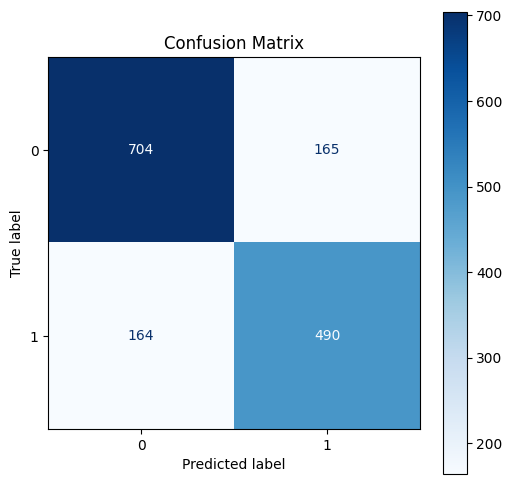

In [38]:
# Calculate the confusion matrix
cm = confusion_matrix(y_val, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Confusion Matrix')
plt.show()

### Model 1 Results

The vanilla RNN results show a pattern of overfitting beyond the 3rd epoch. The training accuracy increases and the training loss decreases over the 10 epochs. However, the validation accuracy peaks around epoch 3 and then starts to decrease, while the validation loss increases steadily after epoch 2. This divergence between the training and validation curves indicates that the model is failing to generalize to unseen data.

### Model 2

The second model is an LSTM (Long Short-Term Memory) network. The structure is similar to the vanilla RNN, replacing the `SimpleRNN` layer with an `LSTM` layer that has 64 units. LSTMs have a complex internal structure, consisting of both a hidden state vector as well as "cell state" vector for retaining longer-term details.

In [39]:
model_LSTM = Sequential([
        # Embedding layer, initialized with pre-trained GloVe weights
        Embedding(
            input_dim=VOCAB_SIZE,
            output_dim=EMBEDDING_DIMENSION,
            weights=[embedding_matrix],
            input_length=MAX_SEQUENCE_LENGTH,
            trainable=True,  # Allow the embeddings to be adjusted in backpropagation
            name='embedding_layer'
        ),
        LSTM(64, name='LSTM_layer'),

        # Dropout layer for the classifier to prevent overfitting
        Dropout(0.5, name='dropout_layer'),

        # Final binary classifier
        Dense(1, activation='sigmoid', name='output_layer') # Custom name for the Dense layer
    ], name='LSTM_model')

model_LSTM.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_LSTM.build(input_shape=(None, MAX_SEQUENCE_LENGTH))
model_LSTM.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "LSTM_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ (None, 31, 100)        │     2,270,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_layer (LSTM)               │ (None, 64)             │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,312,405 (8.82 MB)

 Trainable params: 2,312,405 (8.82 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
EPOCHS_2 = 10
history_2 = model_LSTM.fit(
    X_train, y_train,
    epochs=EPOCHS_2,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.7045 - loss: 0.5571 - val_accuracy: 0.7971 - val_loss: 0.4528
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8347 - loss: 0.4001 - val_accuracy: 0.8207 - val_loss: 0.4198
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8799 - loss: 0.3050 - val_accuracy: 0.8293 - val_loss: 0.4441
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9185 - loss: 0.2165 - val_accuracy: 0.7807 - val_loss: 0.5201
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9487 - loss: 0.1358 - val_accuracy: 0.8116 - val_loss: 0.5452
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9683 - loss: 0.0865 - val_accuracy: 0.7873 - val_loss: 0.6736
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9887 - loss: 0.0385 - val_accuracy: 0.8050 - val_loss: 0.6888
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9943 - loss: 0.0210 - val_accu

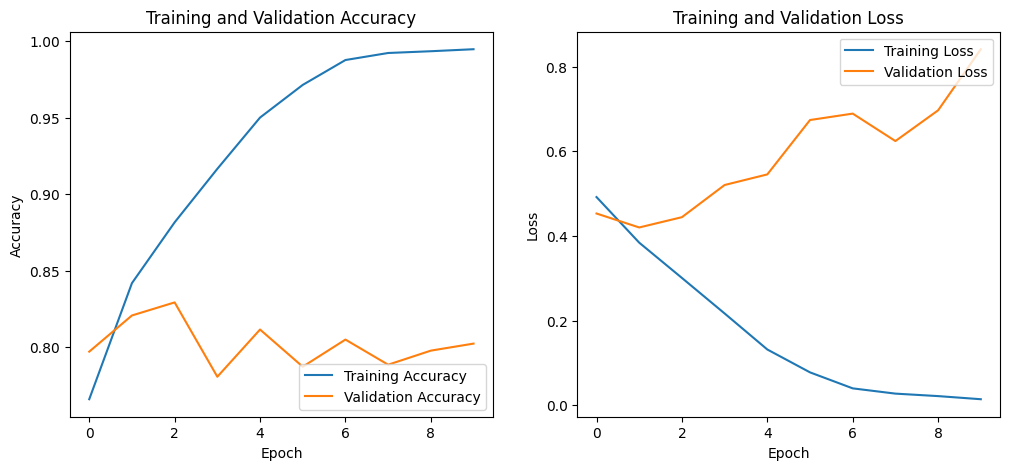

In [41]:
# Get the metrics from the history object
acc_2 = history_2.history['accuracy']
val_acc_2 = history_2.history['val_accuracy']
loss_2 = history_2.history['loss']
val_loss_2 = history_2.history['val_loss']

epochs_range = range(EPOCHS_2)

plt.figure(figsize=(12, 5))

# Plot 1: Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_2, label='Training Accuracy')
plt.plot(epochs_range, val_acc_2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Plot 2: Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_2, label='Training Loss')
plt.plot(epochs_range, val_loss_2, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

In [42]:
# Make predictions on the validation set
y_pred_prob = model_LSTM.predict(X_val)
y_pred = (y_pred_prob > 0.5).astype(int) # Convert probabilities to binary predictions

# Calculate precision, recall, and F1-score
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Precision: 0.7908
Recall: 0.7339
F1-score: 0.7613


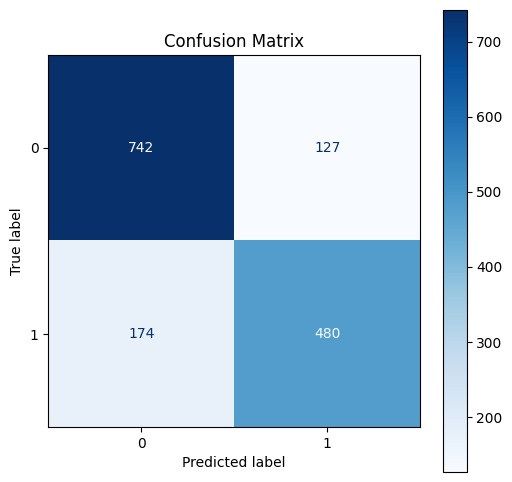

In [43]:
# Calculate the confusion matrix
cm = confusion_matrix(y_val, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Confusion Matrix')
plt.show()

### Model 2 Results

The LSTM model also shows patterns of overfitting, similar to the vanilla RNN, but worse. The model fits the training data well, but validation performance shows that the model fails to generalize.

It's a little surprising that the LSTM model did not outperform the simpler vanilla RNN, since the complexity of the model with its "forget" gates in theory should reduce the vanishing gradient problem. The poor performance could be attributed to the LSTM's greater number of parameters, which require more training data to learn effectively and can lead to overfitting on smaller datasets or shorter sequences like these tweets. It's possible that these tweets are so short, there is not enough information in the sequence to cause the gradient to "vanish", so there might be only a disadvantage in using the more complex LSTM architecture.

### Model 3

The third model is a Gated Recurrent Unit (GRU) network. The structure replaces the `SimpleRNN` layer with a `GRU` layer, which also has 64 units. GRUs have fewer gates than LSTMs, making them simpler and computationally less expensive.

In [44]:
model_GRU = Sequential([
        # Embedding layer, initialized with pre-trained GloVe weights
        Embedding(
            input_dim=VOCAB_SIZE,
            output_dim=EMBEDDING_DIMENSION,
            weights=[embedding_matrix],
            input_length=MAX_SEQUENCE_LENGTH,
            trainable=True,  # Allow the embeddings to be adjusted in backpropagation
            name='embedding_layer'
        ),
        GRU(64, name='GRU_layer'),

        # Dropout layer for the classifier to prevent overfitting
        Dropout(0.5, name='dropout_layer'),

        # Final binary classifier
        Dense(1, activation='sigmoid', name='output_layer') # Custom name for the Dense layer
    ], name='GRU_model')

model_GRU.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_GRU.build(input_shape=(None, MAX_SEQUENCE_LENGTH))
model_GRU.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "GRU_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ (None, 31, 100)        │     2,270,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ GRU_layer (GRU)                 │ (None, 64)             │        31,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,302,037 (8.78 MB)

 Trainable params: 2,302,037 (8.78 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
EPOCHS_3 = 10
history_3 = model_GRU.fit(
    X_train, y_train,
    epochs=EPOCHS_3,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.6520 - loss: 0.6202 - val_accuracy: 0.8247 - val_loss: 0.4116
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8439 - loss: 0.3865 - val_accuracy: 0.8273 - val_loss: 0.4035
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8847 - loss: 0.2943 - val_accuracy: 0.8168 - val_loss: 0.4356
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9198 - loss: 0.2084 - val_accuracy: 0.8207 - val_loss: 0.5330
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9682 - loss: 0.0915 - val_accuracy: 0.8070 - val_loss: 0.5401
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9858 - loss: 0.0448 - val_accuracy: 0.7866 - val_loss: 0.6925
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9940 - loss: 0.0229 - val_accuracy: 0.8063 - val_loss: 0.7152
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9941 - loss: 0.0210 - val_accu

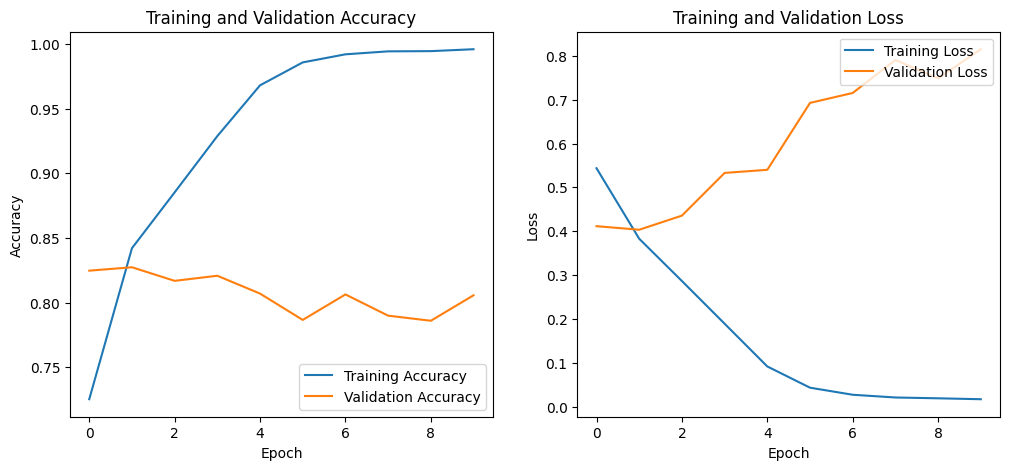

In [46]:
# Get the metrics from the history object
acc_3 = history_3.history['accuracy']
val_acc_3 = history_3.history['val_accuracy']
loss_3 = history_3.history['loss']
val_loss_3 = history_3.history['val_loss']

epochs_range = range(EPOCHS_3)

plt.figure(figsize=(12, 5))

# Plot 1: Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_3, label='Training Accuracy')
plt.plot(epochs_range, val_acc_3, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Plot 2: Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_3, label='Training Loss')
plt.plot(epochs_range, val_loss_3, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

In [47]:
# Make predictions on the validation set
y_pred_prob = model_GRU.predict(X_val)
y_pred = (y_pred_prob > 0.5).astype(int) # Convert probabilities to binary predictions

# Calculate precision, recall, and F1-score
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Precision: 0.8243
Recall: 0.6957
F1-score: 0.7546


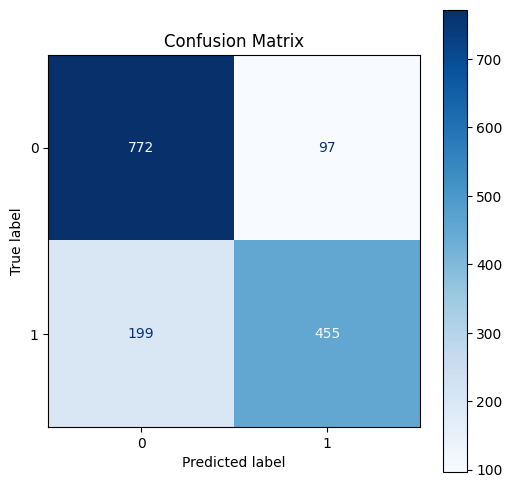

In [48]:
# Calculate the confusion matrix
cm = confusion_matrix(y_val, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Confusion Matrix')
plt.show()

### Model 3 Results

The GRU model, like the other models, also shows signs of overfitting. Comparing the GRU's performance to the LSTM, the GRU model achieved a slightly lower F1-score on the validation set compared to the LSTM. The GRU also showed a lower recall than the LSTM, meaning it was slightly worse at identifying actual disaster tweets. However, the GRU had a higher precision (meaning it was more conservative in assigning positives). Compared to the vanilla RNN, the GRU performed poorly, indicating that, despite the GRU's relative simplicity compared to the LSTM, the dataset is still too small to justify the added complexity of the GRU when compared to the vanilla RNN.

## Test Set Submission

In [49]:
# Get the text from the test DataFrame
test_texts = test_df['text']

# Use the same tokenizer to convert text to sequences of integers
test_sequences = tokenizer.texts_to_sequences(test_texts)

# Use the same padding length to make sequences uniform
X_test = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

print(f"Shape of preprocessed test data (X_test): {X_test.shape}")


predictions = model_vanilla_RNN.predict(X_test)
predicted_labels = (predictions > 0.5).astype(int)
predicted_labels = predicted_labels.flatten()

print(f"Sample predictions (first 5): {predicted_labels[:5]}")

submission_df = pd.DataFrame({
    'id': test_df['id'],
    'target': predicted_labels
})

submission_df.to_csv('submission.csv', index=False)

print(submission_df.head())

Shape of preprocessed test data (X_test): (3263, 31)
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Sample predictions (first 5): [1 1 1 1 1]
   id  target
0   0       1
1   2       1
2   3       1
3   9       1
4  11       1


## Conclusion

In this notebook, I compared the performance of three RNN models (vanilla RNN, LSTM, and GRU) for classifying disaster tweets.

All models showed signs of overfitting.

The vanilla RNN model performed best on the validation set, and for this reason I used that model to run inference against the test dataset. My public accuracy score from Kaggle was ~.78. Obviously, there is much room for improvement.

I also experimented with increasing the hidden state size from 64 to 128 on the models, but this did not significantly improve results and sometimes made them slightly worse. To improve the models, techniques like bidirectional RNNs and more text preprocessing (stemming, lemmatization) would be worth pursuing.